In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy
import warnings 
warnings.filterwarnings('ignore')

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
import seaborn as sns
import numpy as np
import pandas as pd
import re
from konlpy.tag import Okt
okt = Okt()

In [35]:
"""한글, 숫자, 영어 빼고 전부 제거"""
def sub_special(s):
  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',s)
STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다','로']
def morph(s):
  token_ls = []
  #형태소 분석
  s = sub_special(s)
  tmp = okt.morphs(s, stem=True)

  #불용어 처리
  for token in tmp:
    if token not in STOP_WORDS:
      token_ls.append(token)
  return token_ls

In [25]:
movie = pd.read_csv('/content/gdrive/My Drive/recom_dev/crawling/data/genre_rec_movie.csv')
movie.drop(['Unnamed: 0'], axis = 1, inplace=True)
movie.head(5)

,title,genre,ratings,cast,summary,numberofpeople,imagelink
0,포드 V 페라리,액션,관람객 평점 9.31점,"['맷 데이먼', '크리스찬 베일']",자존심을 건 대결의 시작!,"1,118",https://movie-phinf.pstatic.net/20191204_91/15...
1,감쪽같은 그녀,드라마,관람객 평점 8.83점,"['나문희', '김수안']",“초면에 실례하겠습니다~”\n 72살 나 홀로 라이프를 즐기는 ‘말순’ 할매의 인생...,208,https://movie-phinf.pstatic.net/20191204_6/157...
2,백두산,드라마,관람객 평점 7.47점,"['이병헌', '하정우', '마동석']",대한민국 관측 역사상 최대 규모의 백두산 폭발 발생.\n 갑작스러운 재난에 한반도는...,"2,828",https://movie-phinf.pstatic.net/20191219_263/1...
3,시동,드라마,관람객 평점 8.68점,"['마동석', '박정민', '정해인']",학교도 싫고 집도 싫고 공부는 더더욱 싫다며\n '엄마'(염정아)에게 1일 1강스파...,"1,780",https://movie-phinf.pstatic.net/20200117_56/15...
4,블랙머니,범죄,관람객 평점 8.75점,"['조진웅', '이하늬']",고발은 의무! 수사는 직진!\n할말은 하고 깔 건 깐다!,862,https://movie-phinf.pstatic.net/20191113_203/1...


결측값 확인

In [26]:
movie.isnull().sum()

title              0
genre              0
ratings           78
cast               0
summary            1
numberofpeople     0
imagelink          0
dtype: int64

평점이 null인 행만 추출

In [27]:
movie[movie['ratings'].isnull()][:5]

,title,genre,ratings,cast,summary,numberofpeople,imagelink
49,이터널스,액션,NaN,"['안젤리나 졸리', '마동석', '리차드 매든']","잭 커비의 코믹북을 원작으로, 수백만 년 전 인류를 실험하기 위해 지구로 온 셀레스...",0,https://movie-phinf.pstatic.net/20190813_248/1...
63,미친사랑,드라마,NaN,"['공형진', '이시원', '송재림']",과거 북파 공작원으로 활동했던 남자(두식)는 고향(남한)으로도 돌아가지 못한 채 수...,0,https://movie-phinf.pstatic.net/20190530_108/1...
67,아이언맨,SF,NaN,"['로버트 다우니 주니어', '테렌스 하워드', '제프 브리지스']",하이테크 슈퍼 히어로의 탄생 | 이제 업그레이드는 끝났다,0,https://movie-phinf.pstatic.net/20111222_37/13...
70,헬보이 2: 골든 아미,SF,NaN,"['론 펄먼', '셀마 블레어', '더그 존스']",잘생긴 얼굴만 세상을 구하는 건 아니지!,0,https://movie-phinf.pstatic.net/20111222_198/1...
74,해리 포터와 비밀의 방,판타지,NaN,"['다니엘 래드클리프', '루퍼트 그린트', '엠마 왓슨']",해리 포터에겐 이번 여름방학이 별로 즐겁질 못했다. 마법이라면 질색을 하는 페투니아...,0,https://movie-phinf.pstatic.net/20111222_244/1...


ratings이 null인 값들을 직접 naver 영화에서 검색해보았다. 
아직까지 개봉하지 않은 영화이거나, 개봉했으나 관람객 평점이 존재하지 않는 경우이므로 추천하는데에 무의미한 데이터라 생각하고 drop 하여 삭제하는 것으로 결정하였다.

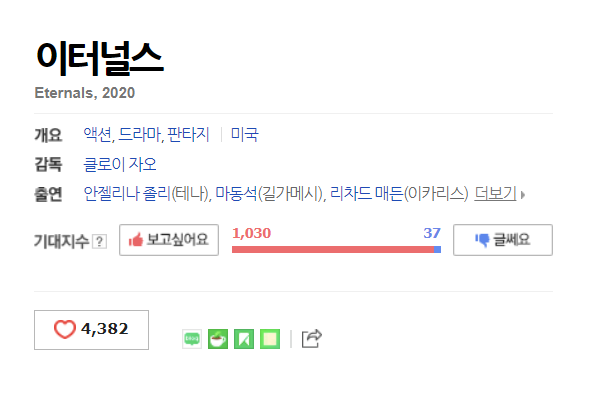 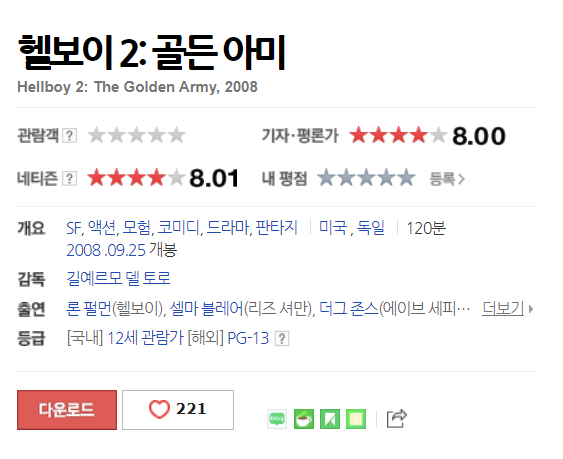

In [28]:
movie[movie['summary'].isnull()][:5]

,title,genre,ratings,cast,summary,numberofpeople,imagelink
154,007 노 타임 투 다이,액션,NaN,"['다니엘 크레이그', '라미 말렉', '라샤나 린치']",NaN,0,https://movie-phinf.pstatic.net/20200305_156/1...


마찬가지로 summary가 null인 영화 또한 ratings가 존재하지 않았으므로, 삭제 처리한다.

In [29]:
movie = movie.dropna()
movie.isnull().sum()

title             0
genre             0
ratings           0
cast              0
summary           0
numberofpeople    0
imagelink         0
dtype: int64

In [30]:
movie.reset_index(inplace = True)
movie.drop(['index'], axis=1, inplace = True)

줄거리를 형태소 분리하여 띄워쓰기로 구분한다.

In [37]:
movie['summary_keywords'] = ''
for i in range(len(movie)):
  movie['summary_keywords'][i] = ' '.join(set(morph(movie['summary'][i])))

movie.head(5)

,title,genre,ratings,cast,summary,numberofpeople,imagelink,summary_keywords
0,포드 V 페라리,액션,관람객 평점 9.31점,"['맷 데이먼', '크리스찬 베일']",자존심을 건 대결의 시작!,"1,118",https://movie-phinf.pstatic.net/20191204_91/15...,대결 시작 건 자존심
1,감쪽같은 그녀,드라마,관람객 평점 8.83점,"['나문희', '김수안']",“초면에 실례하겠습니다~”\n 72살 나 홀로 라이프를 즐기는 ‘말순’ 할매의 인생...,208,https://movie-phinf.pstatic.net/20191204_6/157...,순은 말순 동생 하루 와의 지내다 성격 모든 필요하다 갓난 되어다 나 용돈 갈수록 ...
2,백두산,드라마,관람객 평점 7.47점,"['이병헌', '하정우', '마동석']",대한민국 관측 역사상 최대 규모의 백두산 폭발 발생.\n 갑작스러운 재난에 한반도는...,"2,828",https://movie-phinf.pstatic.net/20191219_263/1...,남 최대 발생 분투 대한민국 하고 만들다 되다 최지영 백두산 비밀 지은 창 하정우 ...
3,시동,드라마,관람객 평점 8.68점,"['마동석', '박정민', '정해인']",학교도 싫고 집도 싫고 공부는 더더욱 싫다며\n '엄마'(염정아)에게 1일 1강스파...,"1,780",https://movie-phinf.pstatic.net/20200117_56/15...,나가다 남다르다 찾다 더 인사 석 학교 빨리 세상 최대 아 집 1 마동석 첫 나누다...
4,블랙머니,범죄,관람객 평점 8.75점,"['조진웅', '이하늬']",고발은 의무! 수사는 직진!\n할말은 하고 깔 건 깐다!,862,https://movie-phinf.pstatic.net/20191113_203/1...,건 직진 고발 의무 깔다 수사


ratings를 평점만 남긴 데이터로 전처리한다.

In [44]:
for i in range(len(movie)):
  rating = movie['ratings'][i]
  movie['ratings'][i] = float(rating[6:len(rating)-1])

movie.head(5)

,title,genre,ratings,cast,summary,numberofpeople,imagelink,summary_keywords
0,포드 V 페라리,액션,9.31,"['맷 데이먼', '크리스찬 베일']",자존심을 건 대결의 시작!,"1,118",https://movie-phinf.pstatic.net/20191204_91/15...,대결 시작 건 자존심
1,감쪽같은 그녀,드라마,8.83,"['나문희', '김수안']",“초면에 실례하겠습니다~”\n 72살 나 홀로 라이프를 즐기는 ‘말순’ 할매의 인생...,208,https://movie-phinf.pstatic.net/20191204_6/157...,순은 말순 동생 하루 와의 지내다 성격 모든 필요하다 갓난 되어다 나 용돈 갈수록 ...
2,백두산,드라마,7.47,"['이병헌', '하정우', '마동석']",대한민국 관측 역사상 최대 규모의 백두산 폭발 발생.\n 갑작스러운 재난에 한반도는...,"2,828",https://movie-phinf.pstatic.net/20191219_263/1...,남 최대 발생 분투 대한민국 하고 만들다 되다 최지영 백두산 비밀 지은 창 하정우 ...
3,시동,드라마,8.68,"['마동석', '박정민', '정해인']",학교도 싫고 집도 싫고 공부는 더더욱 싫다며\n '엄마'(염정아)에게 1일 1강스파...,"1,780",https://movie-phinf.pstatic.net/20200117_56/15...,나가다 남다르다 찾다 더 인사 석 학교 빨리 세상 최대 아 집 1 마동석 첫 나누다...
4,블랙머니,범죄,8.75,"['조진웅', '이하늬']",고발은 의무! 수사는 직진!\n할말은 하고 깔 건 깐다!,862,https://movie-phinf.pstatic.net/20191113_203/1...,건 직진 고발 의무 깔다 수사


numberofpeople 또한 int형으로 바꾸어준다..

In [57]:
for i in range(len(movie)):
  if type(movie['numberofpeople'][i]) != int and ',' in movie['numberofpeople'][i]:
    a = list(movie['numberofpeople'][i])
    a.pop(a.index(','))
    a = ''.join(a)
    movie['numberofpeople'][i] = int(a)
  else:
    movie['numberofpeople'][i] = int(movie['numberofpeople'][i])

가중 평점 = (v/(v+m)) R + (m/(v+m)) \ C

* v: 개별 영화에 평점을 투표한 횟수
* m: 평점을 부여하기 위한 최소 투표 횟수
* R: 개별 영화에 대한 평균 평점
* C: 전체 영화에 대한 평균 평점


v 는 'vote_count' 값이며, R은 'vote_average' 값에 해당합니다. C의 경우 전체 영화의 평균 평점이므로 movies['ratings'].mean()으로 구할 수 있습니다.
m 의 경우는 투표 횟수에 따른 가중치를 직접 조절하는 역할을 하는데, m을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 주게 됩니다.
여기서는 m을 상위 60% 해당하는 횟수를 기준으로 정하겠습니다.

In [58]:
C = movie['ratings'].mean()
m = movie['numberofpeople'].quantile(0.6)
print('C:',round(C,3),'m:',round(m,3))

C: 8.465 m: 312.4


In [60]:
percentile = 0.6
C = movie['ratings'].mean()
m = movie['numberofpeople'].quantile(0.6)

def weighted_ratings_average(record):
  v = record['numberofpeople']
  R = record['ratings']

  return ((v/(v+m)) * R) +( (m/(v+m)) * C)

movie['weighted_ratings'] = movie.apply(weighted_ratings_average, axis = 1)
movie.head(5)

,title,genre,ratings,cast,summary,numberofpeople,imagelink,summary_keywords,weighted_ratings
0,포드 V 페라리,액션,9.31,"['맷 데이먼', '크리스찬 베일']",자존심을 건 대결의 시작!,1118,https://movie-phinf.pstatic.net/20191204_91/15...,대결 시작 건 자존심,9.125471
1,감쪽같은 그녀,드라마,8.83,"['나문희', '김수안']",“초면에 실례하겠습니다~”\n 72살 나 홀로 라이프를 즐기는 ‘말순’ 할매의 인생...,208,https://movie-phinf.pstatic.net/20191204_6/157...,순은 말순 동생 하루 와의 지내다 성격 모든 필요하다 갓난 되어다 나 용돈 갈수록 ...,8.610942
2,백두산,드라마,7.47,"['이병헌', '하정우', '마동석']",대한민국 관측 역사상 최대 규모의 백두산 폭발 발생.\n 갑작스러운 재난에 한반도는...,2828,https://movie-phinf.pstatic.net/20191219_263/1...,남 최대 발생 분투 대한민국 하고 만들다 되다 최지영 백두산 비밀 지은 창 하정우 ...,7.568989
3,시동,드라마,8.68,"['마동석', '박정민', '정해인']",학교도 싫고 집도 싫고 공부는 더더욱 싫다며\n '엄마'(염정아)에게 1일 1강스파...,1780,https://movie-phinf.pstatic.net/20200117_56/15...,나가다 남다르다 찾다 더 인사 석 학교 빨리 세상 최대 아 집 1 마동석 첫 나누다...,8.647913
4,블랙머니,범죄,8.75,"['조진웅', '이하늬']",고발은 의무! 수사는 직진!\n할말은 하고 깔 건 깐다!,862,https://movie-phinf.pstatic.net/20191113_203/1...,건 직진 고발 의무 깔다 수사,8.674212


In [61]:
movie.columns = ['title','genre','vote','cast','summary','vote_count','image','summary_keyword','weighted_vote']

* 가중 평점을 적용하지 않은 평점 순위 Top 10

In [64]:
movie[['title','vote','weighted_vote','vote_count']].sort_values('vote', ascending=False)[:10]

,title,vote,weighted_vote,vote_count
101,러브 앳,10,8.479689,3
186,앨리스 죽이기,10,8.474854,2
262,체 게바라: 2부 게릴라,10,8.469987,1
224,집으로...,10,8.498729,7
273,쿵푸 보이,10,8.479689,3
194,발리: 천상의 울림,10,8.469987,1
287,너의 목소리,10,8.474854,2
260,퍼펙트 타겟,10,8.469987,1
191,물의 기억,10,8.479689,3
7,사선의 끝,10,8.474854,2


* 가중 평점을 적용한 Top 10

In [63]:
movie[['title','vote','weighted_vote','vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote,weighted_vote,vote_count
326,어벤져스: 엔드게임,9.5,9.490055,32197
38,보헤미안 랩소디,9.45,9.427143,13149
34,그린 북,9.55,9.407857,2072
50,알라딘,9.42,9.386278,8534
37,가버나움,9.54,9.343210,1394
31,항거:유관순 이야기,9.39,9.254690,1823
231,스파이더맨: 뉴 유니버스,9.38,9.247210,1840
315,위대한 쇼맨,9.31,9.247131,3886
283,뽀로로 극장판 보물섬 대모험,9.35,9.223271,1869
217,극한직업,9.2,9.185950,16028


In [65]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df = 0, ngram_range=(1,2))
summ_mat = count_vect.fit_transform(movie['summary_keyword'])
print(summ_mat.shape)

(334, 9076)


In [66]:
summ_sim = cosine_similarity(summ_mat, summ_mat)
summ_sim_sorted_ind = summ_sim.argsort()[:,::-1] #유사도가 높은 순으로 정리된 summ_sim 객체의 비교 행 위치 값을 얻을 수 있습니다.

추출해냈던 `summary_keywords`에 대해 코사인 유사도를 구하여 줄거리 키워드가 유사한 영화 상위 10개를 추천해보자

In [71]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
    # 인자로 입력된 df에서 'title' 칼럼이 입력된 title_name 값인 데이터프레임 추출
    title_movie = df[df['title'] == title_name]

    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1) #1차원 array로 변경

    similar_indexes = similar_indexes[similar_indexes != title_index]

    return df.iloc[similar_indexes].sort_values('weighted_vote',ascending=False)[:top_n]

In [72]:
similar_movies = find_sim_movie(movie, summ_sim_sorted_ind, '어벤져스: 엔드게임', 10)
similar_movies[['title','vote','weighted_vote']]

,title,vote,weighted_vote
140,드래곤 길들이기 3,9.26,9.142275
64,어벤져스: 인피니티 워,9.08,9.067383
297,언더독,9.47,9.006560
130,스파이더맨: 파 프롬 홈,8.99,8.957160
25,호텔 뭄바이,9.09,8.645708
240,다크 나이트,9.65,8.617171
158,존 윅 3: 파라벨룸,8.64,8.604711
323,터미네이터: 다크 페이트,8.56,8.543801
63,판의 미로 - 오필리아와 세 개의 열쇠,9.13,8.540562
306,악인전,8.55,8.539018


In [73]:
similar_movies = find_sim_movie(movie, summ_sim_sorted_ind, '보헤미안 랩소디', 10)
similar_movies[['title','vote','weighted_vote']]

,title,vote,weighted_vote
59,토이 스토리 4,9.23,9.151042
16,기생충,9.07,9.047028
130,스파이더맨: 파 프롬 홈,8.99,8.957160
181,김복동,9.84,8.949615
6,조커,8.97,8.936907
205,어른이 되면,9.74,8.794860
298,신의 한 수: 귀수편,8.69,8.646826
18,라이온 킹,8.64,8.622500
120,로망,8.98,8.573177
323,터미네이터: 다크 페이트,8.56,8.543801


어벤져스를 시도했을 땐 나름 유사한 영화들이 추천되는 것처럼 보이지만, 보헤미안 랩소디로 해 보았을 때엔 *토이 스토리 4, 기생충, 김복동* 등 전혀 관련없어보이는 영화들이 추천된다.

In [76]:
movie[movie['title'] == '토이 스토리 4']

,title,genre,vote,cast,summary,vote_count,image,summary_keyword,weighted_vote
59,토이 스토리 4,애니메이션,9.23,"['톰 행크스', '팀 알렌', '애니 파츠']",우리의 여행은 아직 끝나지 않았다!,2714,https://movie-phinf.pstatic.net/20190611_117/1...,여행 끝나다 우리 아직 않다,9.151042


In [77]:
movie[movie['title'] == '보헤미안 랩소디']

,title,genre,vote,cast,summary,vote_count,image,summary_keyword,weighted_vote
38,보헤미안 랩소디,드라마,9.45,"['라미 말렉', '루시 보인턴', '귈림 리']","“나는 스타가 되지 않을 것이다, 전설이 될 것이다”",13149,https://movie-phinf.pstatic.net/20181213_264/1...,것 되다 전설 이다 나 스타 않다,9.427143


In [78]:
movie[movie['title']=='기생충']

,title,genre,vote,cast,summary,vote_count,image,summary_keyword,weighted_vote
16,기생충,드라마,9.07,"['송강호', '이선균', '조여정']",“폐 끼치고 싶진 않았어요”,7914,https://movie-phinf.pstatic.net/20190528_36/15...,폐 치고 끼 싶다 않다,9.047028


토이스토리4와 기생충의 `summary_keywords`로 확인해 본 결과, `않다` 를 모두 포함하고 있기 때문에 `summary_keywords`에서 다른 것들에 비해 유사하다는 결과를 얻었을 것이라고 예상된다. 이는 원하는 추천 알고리즘에 적합하지 않다.

또한 여기까지 진행하면서, 줄거리의 타이틀만 따오고 exception이 발생하면 전체 내용을 따오는 방식을 -> 줄거리의 타이틀이 존재하면 타이틀**도** 따오고, 거기에 줄거리의 전체 내용을 더하는 방식으로 변경해서 재크롤링해야겠다는 생각이 들었다.